In [1]:
import os
import pandas as pd
from typing import List, Dict

from datacat4ml.const import FETCH_DATA_DIR
from datacat4ml.const import CAT_DATA_DIR, CAT_HHD_OR_DIR, CAT_MHD_OR_DIR, CAT_HHD_GPCR_DIR, CAT_MHD_GPCR_DIR # The LHD dirs are in the corresponding MHD dirs.
from datacat4ml.const import CURA_DATA_DIR, CURA_HHD_OR_DIR, CURA_MHD_OR_DIR, CURA_LHD_OR_DIR, CURA_HHD_GPCR_DIR, CURA_MHD_GPCR_DIR, CURA_LHD_GPCR_DIR
from datacat4ml.const import FEAT_DATA_DIR, FEAT_HHD_OR_DIR , FEAT_MHD_OR_DIR , FEAT_LHD_OR_DIR 
from datacat4ml.const import FEAT_HHD_GPCR_DIR, FEAT_MHD_GPCR_DIR, FEAT_LHD_GPCR_DIR
from datacat4ml.const import SPLIT_DATA_DIR
from datacat4ml.const import CAT_FIG_DIR, CURA_FIG_DIR, FEAT_FIG_DIR

from datacat4ml.utils import mkdirs
from datacat4ml.Scripts.data_prep.data_featurize.delete_failed_smi import hhd_gpcr_failed, mhd_gpcr_failed

# ===================== plotting =====================
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import get_font_names
# Get a list of all available font names in alphabetical order
print(f"Available font names: \n{sorted(get_font_names())}")

#======================= RDKit =======================
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, Draw, PandasTools
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display

Available font names: 
['C059', 'Cantarell', 'D050000L', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Droid Arabic Kufi', 'Droid Sans', 'Droid Sans Armenian', 'Droid Sans Devanagari', 'Droid Sans Ethiopic', 'Droid Sans Fallback', 'Droid Sans Georgian', 'Droid Sans Hebrew', 'Droid Sans Japanese', 'Droid Sans Tamil', 'Droid Sans Thai', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans Narrow', 'P052', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'Source Code Pro', 'URW Bookman', 'URW Gothic', 'Z003', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']


# Fetch

In [2]:
# Greg's maxcurated dataset
Ki_maxcur_path = os.path.join(FETCH_DATA_DIR, 'Ki_maxcur')
IC50_maxcur_path = os.path.join(FETCH_DATA_DIR, 'IC50_maxcur')
EC50_maxcur_path = os.path.join(FETCH_DATA_DIR, 'EC50_maxcur')

The files (greg_max_file) in each above path seems like lhd_gpcr in my workflow, but not exactly.
- Firstly, the grep_max_file is not categorized based on the `patter_regex` I used later
- Secondly, the grep_max_file is not further categorized based on `EFFECT_TYPE_LOOKUP` I used later.
- Thirdly, the number of data points in each greg_max_file is > 100, but lhd_gpcr files can be as small as the data points exists after data curation.

In [3]:
# All datapoints after maxcuration are stored in above 3 dataframes.
ki_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'Ki_gpcr_maxcur_8_data.csv'))
ic50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'IC50_gpcr_maxcur_8_data.csv'))
ec50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'EC50_gpcr_maxcur_8_data.csv'))

/tmp/ipykernel_4071090/4111752224.py:2: DtypeWarning: Columns (11,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ki_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'Ki_gpcr_maxcur_8_data.csv'))
/tmp/ipykernel_4071090/4111752224.py:3: DtypeWarning: Columns (11,14,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ic50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'IC50_gpcr_maxcur_8_data.csv'))
/tmp/ipykernel_4071090/4111752224.py:4: DtypeWarning: Columns (11,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  ec50_gpcr_df = pd.read_csv(os.path.join(FETCH_DATA_DIR, 'EC50_gpcr_maxcur_8_data.csv'))


## assay_info_hash
assay_info_hash cannot distinguish different assays.

# Categorization

## categorized datasets

In [4]:
cat_hhd_or_df = pd.read_csv(os.path.join(CAT_HHD_OR_DIR, 'CHEMBL233', 'Ki', 'CHEMBL233_Ki_hhd_df.csv'))
print(f'The columns in cat_hhd_or_df: \n{cat_hhd_or_df.columns}\n')

cat_hhd_or_df

The columns in cat_hhd_or_df: 
Index(['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id',
       'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'pchembl_value', 'assay_type', 'assay_type_desc',
       'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain',
       'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
       'bao_format', 'bao_label', 'variant_id', 'assay_test_type',
       'assay_desc', 'cell_id', 'tissue_id', 'curated_by', 'relationship_type',
       'relationship_type_desc', 'aidx', 'confidence_score',
       'confidence_score_desc', 'molregno', 'compound_chembl_id',
       'canonical_smiles', 'assay_info_hash'],
      dtype='object')



,assay_id,assay_chembl_id,tid,target_chembl_id,standard_type,standard_relation,standard_value,standard_units,pchembl_value,assay_type,...,curated_by,relationship_type,relationship_type_desc,aidx,confidence_score,confidence_score_desc,molregno,compound_chembl_id,canonical_smiles,assay_info_hash
0,148100,CHEMBL751582,129,CHEMBL233,Ki,=,10620.00,nM,4.97,B,...,Expert,H,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,176210,CHEMBL108417,CC(c1ccccc1)N1CC[C@H]1[C@@H](N)c1cccc(Cl)c1,901e030c965234752af5ce2b09ef2dea
1,148100,CHEMBL751582,129,CHEMBL233,Ki,=,1591.00,nM,5.80,B,...,Expert,H,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,176943,CHEMBL322717,CCCCCCC(c1ccccc1)N1CC[C@H]1[C@@H](N)c1cccc(Cl)c1,901e030c965234752af5ce2b09ef2dea
2,148101,CHEMBL750008,129,CHEMBL233,Ki,NaN,NaN,nM,NaN,B,...,Autocuration,H,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,175456,CHEMBL107536,Cc1cccc([C@H](N)[C@@H]2CCN2C(c2ccccc2)c2ccccc2)c1,901e030c965234752af5ce2b09ef2dea
3,148100,CHEMBL751582,129,CHEMBL233,Ki,=,801.00,nM,6.10,B,...,Expert,H,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,176211,CHEMBL110138,Cc1ccc(C(c2ccc(C)cc2)N2CC[C@H]2[C@H](N)c2cccc(...,901e030c965234752af5ce2b09ef2dea
4,148100,CHEMBL751582,129,CHEMBL233,Ki,=,1599.00,nM,5.80,B,...,Expert,H,Homologous protein target assigned,CLD0,8,Homologous single protein target assigned,176204,CHEMBL110379,CCCCC(c1cccc(F)c1)N1CC[C@H]1[C@H](N)c1cccc(Cl)c1,901e030c965234752af5ce2b09ef2dea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5677,2303201,CHEMBL5264057,129,CHEMBL233,Ki,>,25000.00,nM,NaN,B,...,Autocuration,D,Direct protein target assigned,1474976,9,Direct single protein target assigned,2793954,CHEMBL5274252,COC(=O)[C@]1(c2ccc(Cl)cc2)C[C@@H]1CN1CC[C@]2(C...,1e94001cbea4fad64ab9adc34adbf36d
5678,2303201,CHEMBL5264057,129,CHEMBL233,Ki,>,25000.00,nM,NaN,B,...,Autocuration,D,Direct protein target assigned,1474976,9,Direct single protein target assigned,2811184,CHEMBL5291473,COC(=O)[C@]1(c2ccccc2)C[C@@H]1CN1CC[C@]2(C)c3c...,1e94001cbea4fad64ab9adc34adbf36d
5679,2303201,CHEMBL5264057,129,CHEMBL233,Ki,>,1000.00,nM,NaN,B,...,Autocuration,D,Direct protein target assigned,1474976,9,Direct single protein target assigned,163024,CHEMBL101510,C=CCN1CC[C@@]2(C)c3cc(O)ccc3C[C@H]1[C@H]2C,1e94001cbea4fad64ab9adc34adbf36d
5680,2136489,CHEMBL4880042,129,CHEMBL233,Ki,=,4021.59,nM,5.40,B,...,Autocuration,D,Direct protein target assigned,PDSP_OPRM1,9,Direct single protein target assigned,2446986,CHEMBL4576555,CN1CCN(C(=O)C(C)(C)c2ccc(C(=O)Nc3cn4cc(-c5cc(C...,1e94001cbea4fad64ab9adc34adbf36d


## categorization stats

In [5]:
cat_hhd_or_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_hhd_or_dfs_len.csv'))
cat_hhd_gpcr_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_hhd_gpcr_dfs_len.csv'))
cat_mhd_or_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_mhd_or_dfs_len.csv'))
cat_mhd_gpcr_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_mhd_gpcr_dfs_len.csv'))
cat_lhd_or_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_lhd_or_dfs_len.csv'))
cat_lhd_gpcr_dfs_len = pd.read_csv(os.path.join(CAT_DATA_DIR, 'cat_lhd_gpcr_dfs_len.csv'))

print(f'The shape of cat_hhd_or_dfs_len: {cat_hhd_or_dfs_len.shape}')
print(f'The shape of cat_hhd_gpcr_dfs_len: {cat_hhd_gpcr_dfs_len.shape}')
print(f'The shape of cat_mhd_or_dfs_len: {cat_mhd_or_dfs_len.shape}')
print(f'The shape of cat_mhd_gpcr_dfs_len: {cat_mhd_gpcr_dfs_len.shape}')
print(f'The shape of cat_lhd_or_dfs_len: {cat_lhd_or_dfs_len.shape}')
print(f'The shape of cat_lhd_gpcr_dfs_len: {cat_lhd_gpcr_dfs_len.shape}')

print(f'The columns in cat_hhd_or_dfs_len: \n{cat_hhd_or_dfs_len.columns}\n')

cat_hhd_or_dfs_len.head()

The shape of cat_hhd_or_dfs_len: (12, 13)
The shape of cat_hhd_gpcr_dfs_len: (688, 13)
The shape of cat_mhd_or_dfs_len: (39, 13)
The shape of cat_mhd_gpcr_dfs_len: (1120, 13)
The shape of cat_lhd_or_dfs_len: (35, 13)
The shape of cat_lhd_gpcr_dfs_len: (713, 13)
The columns in cat_hhd_or_dfs_len: 
Index(['df_level', 'use_lookup', 'target', 'effect', 'assay', 'std_type',
       'assay_chembl_id', 'hhd_df', 'effect_type_df', 'plus_df', 'exclude_df',
       'mhd_df', 'lhd_df'],
      dtype='object')



,df_level,use_lookup,target,effect,assay,std_type,assay_chembl_id,hhd_df,effect_type_df,plus_df,exclude_df,mhd_df,lhd_df
0,hhd,NaN,CHEMBL233,NaN,NaN,Ki,NaN,5682,NaN,NaN,NaN,NaN,NaN
1,hhd,NaN,CHEMBL233,NaN,NaN,IC50,NaN,1366,NaN,NaN,NaN,NaN,NaN
2,hhd,NaN,CHEMBL233,NaN,NaN,EC50,NaN,2296,NaN,NaN,NaN,NaN,NaN
3,hhd,NaN,CHEMBL237,NaN,NaN,Ki,NaN,4857,NaN,NaN,NaN,NaN,NaN
4,hhd,NaN,CHEMBL237,NaN,NaN,IC50,NaN,1049,NaN,NaN,NaN,NaN,NaN


In [6]:
cat_mhd_or_dfs_len['mhd_df'].value_counts().sort_index(ascending=False)

mhd_df
5557    1
4997    1
4646    1
1468    1
1332    1
1124    1
964     1
922     1
687     1
587     1
507     1
485     1
377     1
346     1
314     1
267     1
212     1
202     1
197     1
176     1
157     1
91      1
86      1
85      1
80      1
73      1
66      2
63      1
57      1
53      1
47      1
45      1
40      1
38      1
37      1
36      1
33      1
6       1
Name: count, dtype: int64

## cat stats visulaization

### Effectwise
donut plot for effect-wise activity space

In [ ]:
def effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL233', startangle=-90, fig_format='pdf',
                        bind_color= True, agon_color=True, antag_color=True,
                        n_bind_colors=2, n_agon_colors=5, n_antag_colors=3):

    target_len_df = stats_df[stats_df['target'] == target]
    # extract coloums needed for plotting
    if stats_df is cat_mhd_or_dfs_len:
        outer_piece_column = 'mhd_df'
        target_len_df = target_len_df[['effect', 'assay', 'std_type', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'std_type'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('std_type')

        
        minor_labels = target_len_df['assay-type'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    elif stats_df is cat_lhd_or_dfs_len:
        outer_piece_column = 'lhd_df'
        target_len_df = target_len_df[['effect', 'assay', 'std_type', 'assay_chembl_id', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'std_type', 'assay_chembl_id'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type-aid'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('std_type') + ':' + target_len_df.index.get_level_values('assay_chembl_id')

        minor_labels = target_len_df['assay-type-aid'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    ##########Plot the nested pie chart#####################
    # create a figure and subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    width = 0.3

    # data for pie charts
    # Major category values = sum of minor category values
    major_data = target_len_df.groupby('effect')[outer_piece_column].sum()
    major_labels = target_len_df.index.get_level_values('effect').unique()

    # Minor category values
    minor_data = target_len_df[outer_piece_column]

    # create custom colormaps based on a given color
    # color for major category
    major_colors = []
    minor_colors = []
    if agon_color:
        agon_color = '#f5426c'
        major_colors.append(agon_color)
        # minor colors in the order of minor_data
        agon_palette = sns.light_palette(agon_color, n_colors=n_agon_colors)[::-1]

        for i in reversed(range(n_agon_colors)):
            minor_colors.append(agon_palette[i])

    if antag_color:
        antag_color = '#4278f5'
        major_colors.append(antag_color)
        # minor colors in the order of minor_data
        antag_palette = sns.light_palette(antag_color, n_colors=n_antag_colors)[::-1]

        for i in reversed(range(n_antag_colors)):
            minor_colors.append(antag_palette[i])

    if bind_color:
        bind_color = '#b0e3e6'
        major_colors.append(bind_color)
        # minor colors in the order of minor_data
        bind_palette = sns.light_palette(bind_color, n_colors=n_bind_colors)[::-1]

        for i in reversed(range(n_bind_colors)):
            minor_colors.append(bind_palette[i])


    # Draw pies
    hfont = {'fontname':'DejaVu Sans'}
    # pie for major category - 'effect', put in the inner circle
    ax.pie(major_data, 
        radius=1-width, 
        colors=major_colors,
        labels=major_labels,
        startangle=startangle,
        textprops={'fontsize': 13, 'fontweight':'bold', **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=0.6)
    
    # pie for minor category - 'assay', put in the outer circle
    ax.pie(minor_data,
        radius=1,
        colors=minor_colors,
        labels=minor_labels,
        startangle=startangle,
        textprops={'fontsize': 11, **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=1)

    # Set a title
    ax.set_title(f'{target}: effect-wise activity space', fontsize=16, fontweight='bold', **hfont)

    # save the figure
    file_path = os.path.join(CAT_FIG_DIR)
    mkdirs(file_path)

    if stats_df is cat_mhd_or_dfs_len:
        fig.savefig(os.path.join(file_path, f"{target}_mhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')

    elif stats_df is cat_lhd_or_dfs_len:
        fig.savefig(os.path.join(file_path, f"{target}_lhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')
        
    return target_len_df

#### hhd -> mhd 

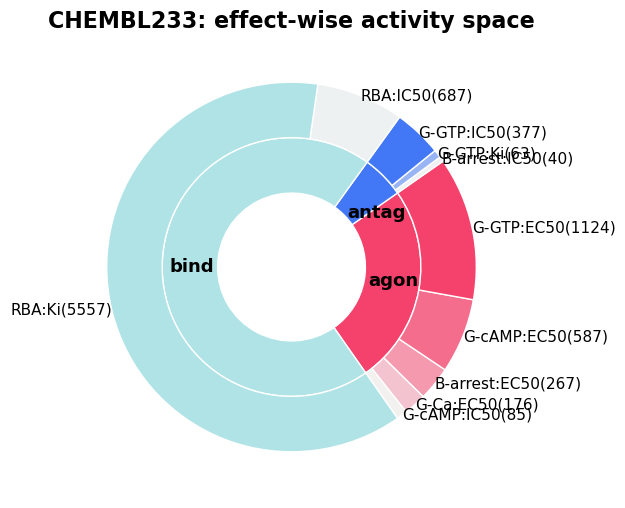

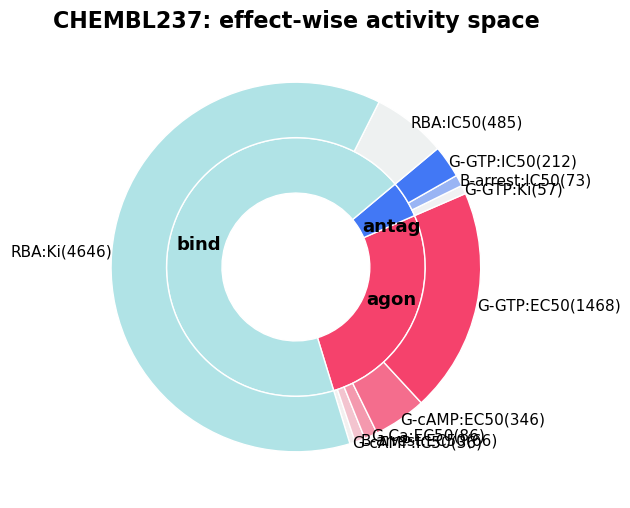

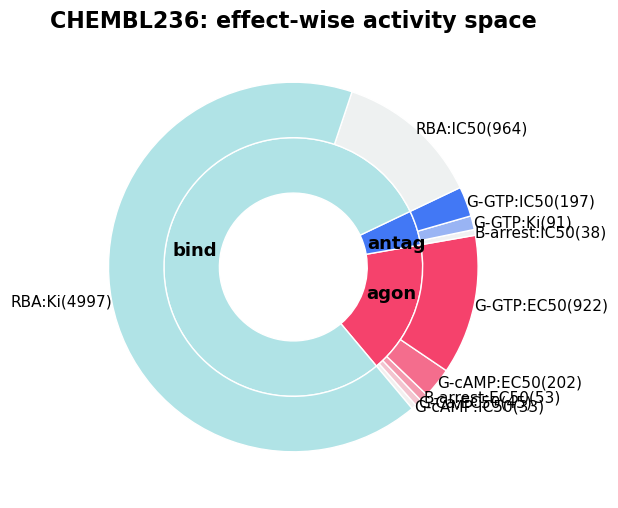

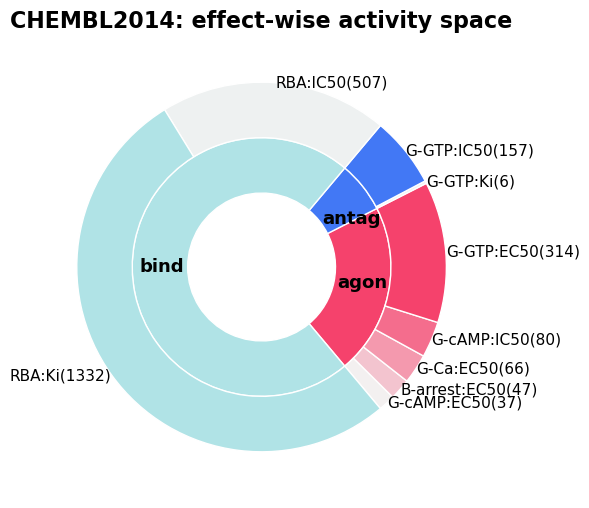

In [8]:
mor_h_mhd_df = effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL233', startangle=-55, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
kor_h_mhd_df = effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL237', startangle=-73, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
dor_h_mhd_df = effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL236', startangle=-50, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=3)
nor_h_mhd_df = effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL2014', startangle=-50, fig_format='pdf',
                                       n_bind_colors=2, n_agon_colors=5, n_antag_colors=2)

In [9]:
mor_h_mhd_df
kor_h_mhd_df
dor_h_mhd_df
dor_h_mhd_df

mhd_df     assay-type
effect assay    std_type                       
agon   G-cAMP   IC50          33    G-cAMP:IC50
       G-Ca     EC50          45      G-Ca:EC50
       B-arrest EC50          53  B-arrest:EC50
       G-cAMP   EC50         202    G-cAMP:EC50
       G-GTP    EC50         922     G-GTP:EC50
antag  B-arrest IC50          38  B-arrest:IC50
       G-GTP    Ki            91       G-GTP:Ki
                IC50         197     G-GTP:IC50
bind   RBA      IC50         964       RBA:IC50
                Ki          4997         RBA:Ki

#### mhd -> lhd 

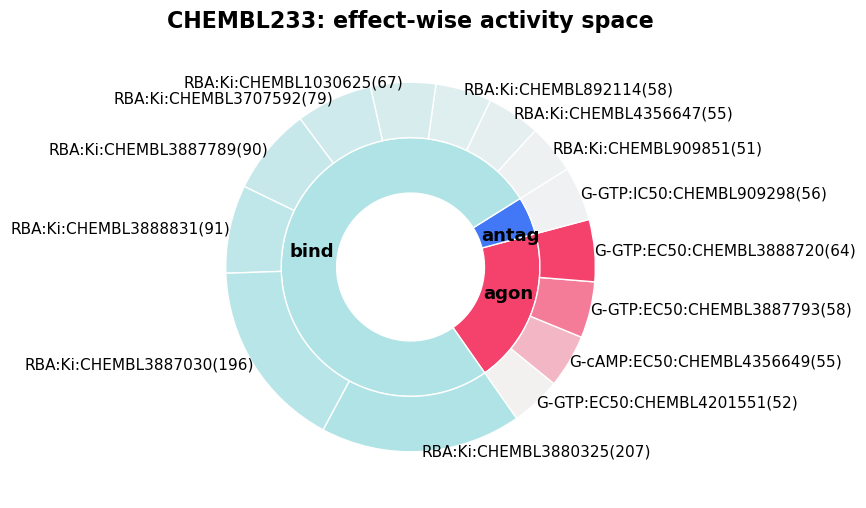

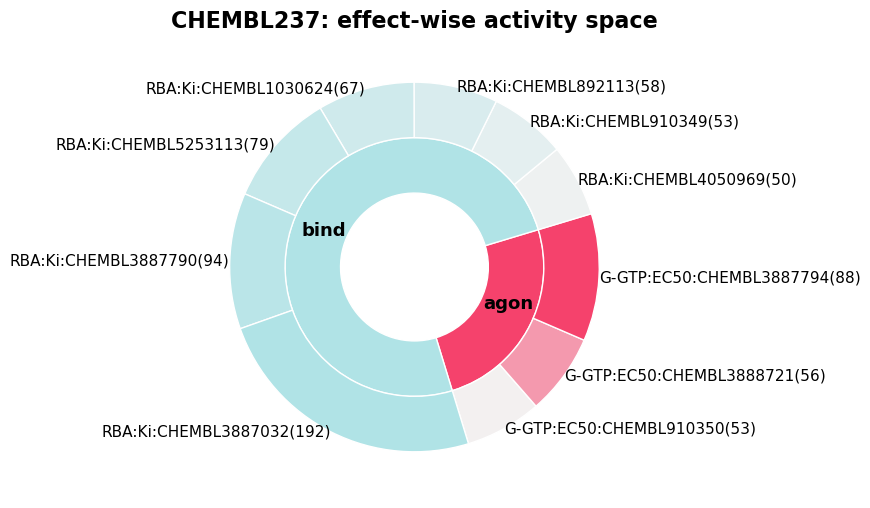

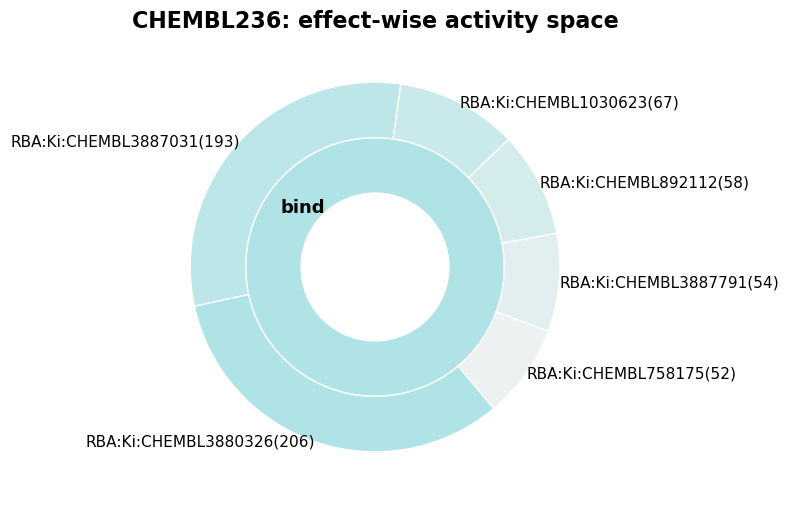

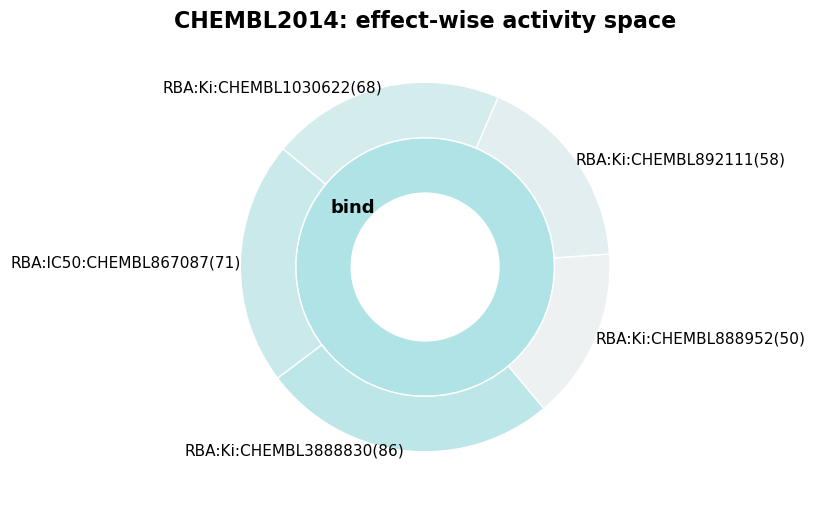

In [10]:
mor_m_lhd_df = effect_activity_space(stats_df=cat_lhd_or_dfs_len, target='CHEMBL233', startangle=-55, fig_format='pdf',
                                       n_bind_colors=9, n_agon_colors=4, n_antag_colors=1)
kor_m_lhd_df = effect_activity_space(stats_df=cat_lhd_or_dfs_len, target='CHEMBL237', startangle=-73, fig_format='pdf',
                                     antag_color=False,
                                       n_bind_colors=7, n_agon_colors=3, n_antag_colors=0)
dor_m_lhd_df = effect_activity_space(stats_df=cat_lhd_or_dfs_len, target='CHEMBL236', startangle=-50, fig_format='pdf',
                                     agon_color=False, antag_color=False,
                                       n_bind_colors=6, n_agon_colors=0, n_antag_colors=0)
nor_m_lhd_df = effect_activity_space(stats_df=cat_lhd_or_dfs_len, target='CHEMBL2014', startangle=-50, fig_format='pdf',
                                     agon_color=False, antag_color=False,
                                       n_bind_colors=6, n_agon_colors=0, n_antag_colors=0)

In [11]:
mor_m_lhd_df
kor_m_lhd_df
dor_m_lhd_df
nor_m_lhd_df

lhd_df         assay-type-aid
effect assay std_type assay_chembl_id                               
bind   RBA   Ki       CHEMBL888952         50    RBA:Ki:CHEMBL888952
                      CHEMBL892111         58    RBA:Ki:CHEMBL892111
                      CHEMBL1030622        68   RBA:Ki:CHEMBL1030622
             IC50     CHEMBL867087         71  RBA:IC50:CHEMBL867087
             Ki       CHEMBL3888830        86   RBA:Ki:CHEMBL3888830

### Typewise
donut plot for type-wise activity space

In [ ]:
def type_activity_space(target='CHEMBL233', startangle=-90, fig_format='pdf'):
    
    target_len_df = final_len_df[final_len_df['target'] == target]
    # extract columns needed for plotting
    target_len_df = target_len_df[['effect', 'assay', 'std_type', 'final_df']]
    # create the pivot table
    target_len_df = pd.pivot_table(target_len_df, index=['std_type', 'effect','assay'], values=['final_df'])
    # make a new column for labeling the minor data
    target_len_df['effect-assay'] = target_len_df.index.get_level_values('effect') + ': ' + target_len_df.index.get_level_values('assay')


    ##########Plot the nested pie chart#####################
    # create a figure and subplots
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.3

    # data for pie charts
    # Major category values = sum of minor category values
    major_data = target_len_df.groupby('std_type')['final_df'].sum()
    major_labels = target_len_df.index.get_level_values('std_type').unique()
    # Minor category values
    minor_data = target_len_df['final_df']
    minor_labels = target_len_df['effect-assay'] + '(' + target_len_df['final_df'].astype(str) + ')'

    # create custom colormaps based on a given color
    # color for major category
    ec50_color = '#b0daff'
    ic50_color = '#19a7ce'
    kb_color = '#146c94'
    ke_color = '#164b60' 
    ki_color = '#c4b0ff' #'#e5beec', #f9f54b

    major_colors = [ec50_color, ic50_color, kb_color, ke_color, ki_color]
    # color for minor category
    ki_palette = sns.light_palette(ki_color, n_colors=2)[::-1]
    ic50_palette = sns.light_palette(ic50_color, n_colors=4)[::-1]
    ec50_palette = sns.light_palette(ec50_color, n_colors=4)[::-1]
    ke_palette = sns.light_palette(ke_color, n_colors=1)[::-1]
    kb_palette = sns.light_palette(kb_color, n_colors=1)[::-1]
    minor_colors = [ec50_palette[3], ec50_palette[2], ec50_palette[1], ec50_palette[0],
                    ic50_palette[3], ic50_palette[2], ic50_palette[1], ic50_palette[0],
                    kb_palette[0],
                    ke_palette[0],
                    ki_palette[1], ki_palette[0]]
    # Draw pies
    hfont = {'fontname':'serif'}
    # pie for major category - 'effect', put in the inner circle
    ax.pie(major_data, 
        radius=1-width, 
        colors=major_colors,
        labels=major_labels,
        startangle=startangle,
        textprops={'fontsize': 11, 'fontweight':'bold'},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=0.65)
    # pie for minor category - 'assay', put in the outer circle
    ax.pie(minor_data,
        radius=1,
        colors=minor_colors,
        labels=minor_labels,
        startangle=startangle,
        textprops={'fontsize': 11, 'fontname':'serif'},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=1)
    
    # Set a title
    ax.set_title(f'{target}: type-wise activity space', fontsize=16, fontweight='bold', **hfont)

    # save the figure
    file_path = os.path.join(CAT_FIG_DIR, target)
    mkdirs(file_path)

    fig.savefig(os.path.join(file_path, f"{target}_type-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')
    print(f"Figure saved in {file_path}")
    
    return target_len_df

In [ ]:
mor_type_len_df = type_activity_space(target='CHEMBL233', startangle=-90, fig_format='pdf')
kor_type_len_df = type_activity_space(target='CHEMBL237', startangle=-103, fig_format='pdf')
dor_type_len_df = type_activity_space(target='CHEMBL236', startangle=-101, fig_format='pdf')
nor_type_len_df = type_activity_space(target='CHEMBL2014', startangle=-100, fig_format='pdf')

# Curation

## curated datasets

In [17]:
cura_lhd_or_f = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_lhd_or', 'CHEMBL233_bind_RBA_Ki_CHEMBL3887789_lhd_b50_curated.csv'))
cura_lhd_or_f_smi = cura_lhd_or_f[['target_chembl_id', 'effect', 'assay', 'std_type', 'assay_chembl_id', 'canonical_smiles', 'canonical_smiles_by_Std']]
cura_lhd_or_f.drop(columns=["Unnamed: 0"], inplace=True)
#cura_lhd_or_f.columns()
#12
cura_lhd_or_f.iloc[:, -13:]

,canonical_smiles_by_Std,molecular_weight,num_atoms,pStandard_value,max_num_atoms,max_molecular_weight,activity_string,activity,threshold,target,effect,assay,std_type
0,CO[C@]12CC[C@@]3(C[C@@H]1COCc1ccccc1C)[C@H]1Cc...,505.655,37,8.380907,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
1,CO[C@]12CC[C@@]3(C[C@@H]1COCc1ccccc1)[C@H]1Cc4...,446.591,33,8.688246,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
2,C=Cc1ccc2c3c1O[C@H]1[C@@]4(OC)CC[C@@]5(C[C@@H]...,457.614,34,7.786217,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
3,CO[C@]12CC[C@@]3(C[C@@H]1COCc1ccccc1)[C@H]1Cc4...,449.566,33,8.355561,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
4,COc1ccc2c3c1O[C@H]1[C@@]4(OC)CC[C@@]5(C[C@@H]4...,553.703,41,7.800519,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,COc1ccc2c3c1O[C@H]1[C@@]4(O)CC[C@@]5(C[C@@H]4C...,487.640,36,8.478862,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
86,COc1ccc2c3c1O[C@H]1[C@@]4(OC)CC[C@@]5(C[C@@H]4...,558.719,41,6.807935,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
87,COc1ccc2c3c1O[C@H]1[C@@]4(OC)CC[C@@]5(C[C@@H]4...,529.641,39,6.006145,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki
88,COc1ccc2c3c1O[C@H]1[C@@]4(OC)CC[C@@]5(C[C@@H]4...,559.703,41,6.303006,54,751.958,active,1.0,5.0,CHEMBL233,bind,RBA,Ki


### 2D structure of SMILES before and after curation

In [ ]:
def display_2d_in_df(df, slice_start=0, slice_end=10):
    """ display the 2D structure of column 'canonical_smiles' and 'canonnical_smiles_by_Std' using rdkit"""

    

    print(f"The shape of the dataframe: {df.shape}")

    df = df.copy()[slice_start:slice_end] 

    # Convert SMILES strings to RDKit molecule objects
    df['before_cura'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)
    df['after_cura'] = df['canonical_smiles_by_Std'].apply(Chem.MolFromSmiles)

    PandasTools.AddMoleculeColumnToFrame(df, "canonical_smiles", "before_cura", includeFingerprints=False)
    PandasTools.AddMoleculeColumnToFrame(df, "canonical_smiles_by_Std", "after_cura", includeFingerprints=False)

    # Display the DataFrame
    display(df)

#display_2d_in_df(df = cura_lhd_or_f_smi, slice_start=70, slice_end=90)

### all numeric columns

In [18]:
# The data type of each column
num_cols_4each_file = ['max_molecular_weight', 'max_num_atoms', 'threshold']
num_cols_4each_comp = ['molecular_weight', 'num_atoms', 'pStandard_value', 'activity']

#### 'molecular_weight'

/storage/homefs/yc24j783/miniconda3/envs/datacat/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 400x200 with 0 Axes>

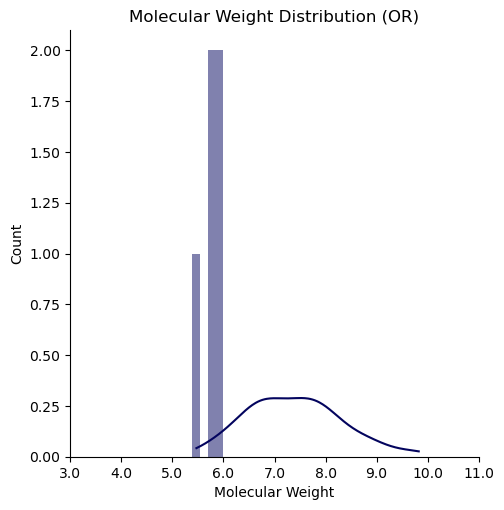

In [ ]:
def histplot_MW(ds_df, ds_type='or'):

    # initialize the fig
    plt.figure(figsize=(4, 2))
    plt.rcParams["font.family"] = "DejaVu Sans"

    # set color based on ds_type
    if ds_type == 'or':
        color = '#03045e' # purple
    elif ds_type == 'gpcr':
        color = '#677bab'  # light purple

    # plot a hisgram of 'molecular_weight'
    sns.displot(data=ds_df, 
                x='pStandard_value', 
                color=color, 
                kde=True, 
                binrange=(4, 6),
                linewidth=0 # remove the border line
                )
    
    # set x, y and title
    plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
    plt.xlabel('Molecular Weight')
    plt.title(f'Molecular Weight Distribution ({ds_type.upper()})')

    # save the figure
    plt.savefig(os.path.join(CURA_FIG_DIR, f'molecular_weight_distribution_{ds_type.upper()}.pdf'), dpi=300, bbox_inches='tight')

histplot_MW(ds_df=cura_lhd_or_f, ds_type='or')

## curation stats

In [7]:
cura_hhd_or_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_hhd_or', 'cura_hhd_or_stats.csv'))
cura_hhd_gpcr_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_hhd_gpcr', 'cura_hhd_gpcr_stats.csv'))
cura_mhd_or_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_mhd_or', 'cura_mhd_or_stats.csv'))
cura_mhd_gpcr_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_mhd_gpcr', 'cura_mhd_gpcr_stats.csv'))
cura_lhd_or_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_lhd_or', 'cura_lhd_or_stats.csv'))
cura_lhd_gpcr_stats = pd.read_csv(os.path.join(CURA_DATA_DIR, 'cura_lhd_gpcr', 'cura_lhd_gpcr_stats.csv'))


print(f'cura_hhd_or_stats: {cura_hhd_or_stats.shape}') #
print(f'cura_hhd_gpcr_stats: {cura_hhd_gpcr_stats.shape}')
print(f'cura_mhd_or_stats: {cura_mhd_or_stats.shape}') #
print(f'cura_mhd_gpcr_stats: {cura_mhd_gpcr_stats.shape}')
print(f'cura_lhd_or_stats: {cura_lhd_or_stats.shape}')
print(f'cura_lhd_gpcr_stats: {cura_lhd_gpcr_stats.shape}')

cura_hhd_or_stats: (12, 13)
cura_hhd_gpcr_stats: (634, 13)
cura_mhd_or_stats: (38, 13)
cura_mhd_gpcr_stats: (983, 13)
cura_lhd_or_stats: (35, 13)
cura_lhd_gpcr_stats: (696, 13)


In [8]:
cura_hhd_or_stats.head()
cura_mhd_or_stats.head()
cura_lhd_or_stats.head()

,ds_level,target,effect,assay,standard_type,assay_chembl_id,raw_size,curated_size,removed_size,threshold,num_active,num_inactive,%_active
0,lhd,CHEMBL233,bind,RBA,Ki,CHEMBL3887030,5557,188,8,5.717605,94.0,94.0,50.00
1,lhd,CHEMBL233,bind,RBA,Ki,CHEMBL3887789,5557,90,0,5.000000,90.0,0.0,100.00
2,lhd,CHEMBL233,bind,RBA,Ki,CHEMBL3888831,5557,57,34,5.000000,57.0,0.0,100.00
3,lhd,CHEMBL233,bind,RBA,Ki,CHEMBL1030625,5557,65,2,5.000000,61.0,4.0,93.85
4,lhd,CHEMBL233,bind,RBA,Ki,CHEMBL892114,5557,53,5,5.000000,47.0,6.0,88.68


## cat stats visualization

### combine or_stats, gpcr_stats

In [9]:
# concate all the cura_*_gpcr_stats dataframes
cura_gpcr_stats = pd.concat([cura_hhd_gpcr_stats, cura_mhd_gpcr_stats, cura_lhd_gpcr_stats], ignore_index=True)
# concate all the cura_*_or_stats dataframes
cura_or_stats = pd.concat([cura_hhd_or_stats, cura_mhd_or_stats, cura_lhd_or_stats], ignore_index=True)
cura_or_stats

,ds_level,target,effect,assay,standard_type,assay_chembl_id,raw_size,curated_size,removed_size,threshold,num_active,num_inactive,%_active
0,hhd,CHEMBL233,NaN,NaN,Ki,NaN,5682,4535,1147,5.0,3913.0,622.0,86.28
1,hhd,CHEMBL233,NaN,NaN,IC50,NaN,1366,1005,361,5.0,810.0,195.0,80.60
2,hhd,CHEMBL233,NaN,NaN,EC50,NaN,2296,1436,860,5.0,1208.0,228.0,84.12
3,hhd,CHEMBL237,NaN,NaN,Ki,NaN,4857,3829,1028,5.0,3284.0,545.0,85.77
4,hhd,CHEMBL237,NaN,NaN,IC50,NaN,1049,770,279,5.0,619.0,151.0,80.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,lhd,CHEMBL237,agon,G-GTP,EC50,CHEMBL3887794,1468,88,0,5.0,87.0,1.0,98.86
81,lhd,CHEMBL237,agon,G-GTP,EC50,CHEMBL3888721,1468,50,6,5.0,42.0,8.0,84.00
82,lhd,CHEMBL237,agon,G-GTP,EC50,CHEMBL910350,1468,29,24,5.0,29.0,0.0,100.00
83,lhd,CHEMBL233,agon,G-cAMP,EC50,CHEMBL4356649,587,55,0,5.0,42.0,13.0,76.36


### 'threshold'

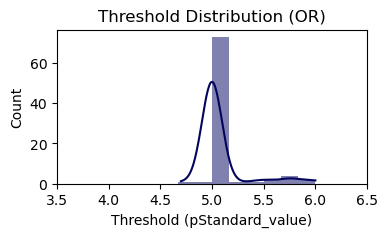

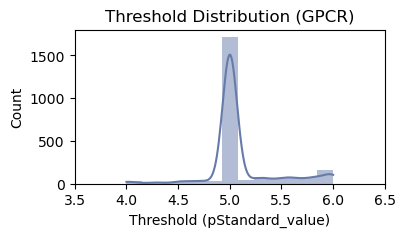

In [ ]:
def histplot_threshold(df=cura_or_stats, ds_type='or'):

    # initialize the fig
    plt.figure(figsize=(4, 2))
    plt.rcParams["font.family"] = "DejaVu Sans"

    # set color based on ds_type
    if ds_type == 'or':
        color = '#03045e' # purple
    elif ds_type == 'gpcr':
        color = '#677bab'  # light purple

    # plot a hisgram of 'threshold'
    sns.histplot(data=df, x='threshold', color=color, kde=True, binrange=(4, 6),
                 linewidth=0 # remove the border line
                 )
    
    # set x, y and title
    plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
    plt.xlabel('Threshold (pStandard_value)')
    plt.title(f'Threshold Distribution ({ds_type.upper()})')

    # save the figure
    plt.savefig(os.path.join(CURA_FIG_DIR, f'threshold_distribution_{ds_type.upper()}.pdf'), dpi=300, bbox_inches='tight')

histplot_threshold(df=cura_or_stats, ds_type='or')
histplot_threshold(df=cura_gpcr_stats, ds_type='gpcr')

### '%_active'

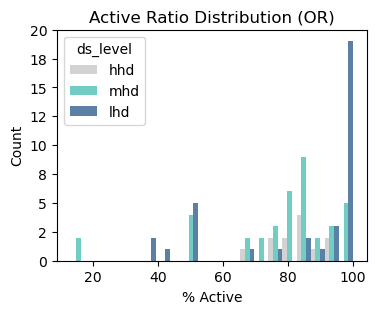

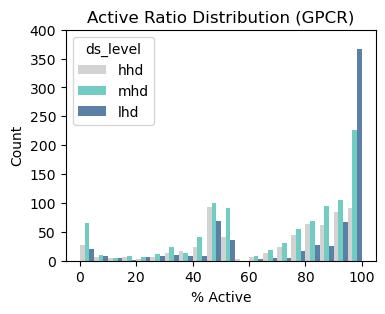

In [10]:
def histplot_active_ratio(df, ds_type='or'):
    """ Plot the distribution of %_active in cura_or_stats or cura_gpcr_stats dataframe.
    
    Params:
    -------
    df: pd.DataFrame
        The dataframe to plot, either cura_or_stats or cura_gpcr_stats.
    ds_type: str
        The type of the dataset, either 'or' or 'gpcr'.

    Returns:
    --------
    None
    """
    # initialize the fig
    plt.figure(figsize=(4,3))
    plt.rcParams["font.family"] = "DejaVu Sans"

    # set color palette
    ds_level_palette = {"lhd":'#235689', 
                        'mhd':'#41BBB1', 
                        'hhd':'#C4C3C3'}

    # plot a histgram
    sns.histplot(
        data=df,
        x="%_active",
        hue="ds_level",        # groups by ds_level
        multiple="dodge",      # "dodge" (not suitable for too many hue levels); "stack" for stacked; "layer" for overlay; "fill" for filled; 
        bins=20,
        palette=ds_level_palette,
        linewidth=0 # remove the border line
    )

    # set x, y and title
    plt.xlabel("% Active")
    plt.ylabel("Count")
    plt.yticks(ticks=plt.yticks()[0], labels=[f'{x:.0f}' for x in plt.yticks()[0]])
    plt.title(f'Active Ratio Distribution ({ds_type.upper()})')

    # save the figure
    if ds_type == 'or':
        plt.savefig(os.path.join(CURA_FIG_DIR, 'active_ratio_distribution_OR.pdf'), dpi=300, bbox_inches='tight')
    elif ds_type == 'gpcr':
        plt.savefig(os.path.join(CURA_FIG_DIR, 'active_ratio_distribution_GPCR.pdf'), dpi=300, bbox_inches='tight')

histplot_active_ratio(df=cura_or_stats, ds_type='or')
histplot_active_ratio(df=cura_gpcr_stats, ds_type='gpcr')

### 'curated_size'

In [44]:
df = cura_or_stats
# print the data type of each column
df

,ds_level,target,effect,assay,standard_type,assay_chembl_id,raw_size,curated_size,removed_size,threshold,num_active,num_inactive,%_active
0,hhd,CHEMBL233,NaN,NaN,Ki,NaN,5682,4535,1147,5.0,3913.0,622.0,86.28
1,hhd,CHEMBL233,NaN,NaN,IC50,NaN,1366,1005,361,5.0,810.0,195.0,80.60
2,hhd,CHEMBL233,NaN,NaN,EC50,NaN,2296,1436,860,5.0,1208.0,228.0,84.12
3,hhd,CHEMBL237,NaN,NaN,Ki,NaN,4857,3829,1028,5.0,3284.0,545.0,85.77
4,hhd,CHEMBL237,NaN,NaN,IC50,NaN,1049,770,279,5.0,619.0,151.0,80.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,'lhd',CHEMBL237,agon,G-GTP,EC50,CHEMBL3888721,1468,50,6,5.0,42.0,8.0,84.00
81,'lhd',CHEMBL237,agon,G-GTP,EC50,CHEMBL910350,1468,29,24,5.0,29.0,0.0,100.00
82,'lhd',CHEMBL237,agon,G-GTP,EC50,CHEMBL3887794,1468,88,0,5.0,87.0,1.0,98.86
83,'lhd',CHEMBL233,agon,G-cAMP,EC50,CHEMBL4356649,587,55,0,5.0,42.0,13.0,76.36


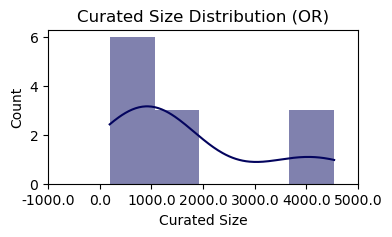

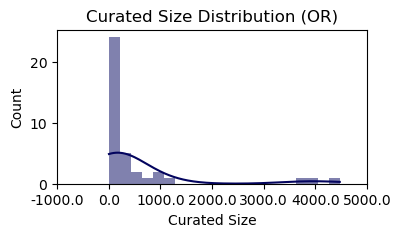

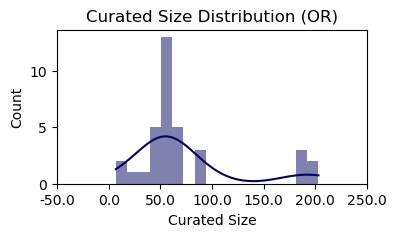

In [51]:
def histplot_size(df=cura_or_stats, ds_type='or'):

    # initialize the fig
    plt.figure(figsize=(4, 2))
    plt.rcParams["font.family"] = "DejaVu Sans"

    # set color based on ds_type
    if ds_type == 'or':
        color = '#03045e' # purple
    elif ds_type == 'gpcr':
        color = '#677bab'  # light purple

    # plot a hisgram of 'threshold'
    sns.histplot(data=df, x='curated_size', 
                 color=color, 
                 kde=True, 
                 #binrange=(4, 6),
                 linewidth=0 # remove the border line
                 )
    
    # set x, y and title
    plt.xticks(ticks=plt.xticks()[0], labels=[f'{x:.1f}' for x in plt.xticks()[0]]) # set the decimal places of x-axis ticks to 1
    plt.xlabel('Curated Size')
    plt.title(f'Curated Size Distribution ({ds_type.upper()})')

    # save the figure
    plt.savefig(os.path.join(CURA_FIG_DIR, f'size_distribution_{ds_type.upper()}.pdf'), dpi=300, bbox_inches='tight')

histplot_size(df=cura_hhd_or_stats, ds_type='or')
histplot_size(df=cura_mhd_or_stats, ds_type='or')
histplot_size(df=cura_lhd_or_stats, ds_type='or')

<Axes: xlabel='standard_type', ylabel='ds_level-target-effect-assay-assay_chembl_id'>

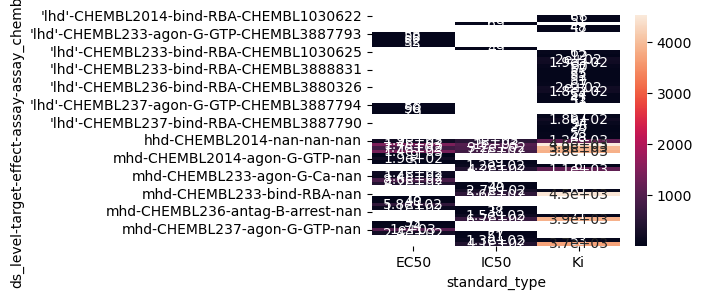

In [ ]:
# initialize the fig
plt.figure(figsize=(4,3))
plt.rcParams["font.family"] = "DejaVu Sans"

# set color palette
ds_level_palette = {"'lhd'":'#235689', 
                    'mhd':'#41BBB1', 
                    'hhd':'#C4C3C3'}
# plot a heatmap
curated_size = df.pivot(index=["ds_level", "target", "effect", "assay", "assay_chembl_id"], columns=["standard_type"], values="curated_size")
curated_size = curated_size.apply(pd.to_numeric, errors="coerce")
#sns.heatmap(curated_size, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=.5, linecolor='gray')
sns.heatmap(curated_size, annot=True)

### effect-wise activity space after curation

In [ ]:
def effect_activity_space(stats_df=cat_mhd_or_dfs_len, target='CHEMBL233', startangle=-90, fig_format='pdf',
                        bind_color= True, agon_color=True, antag_color=True,
                        n_bind_colors=2, n_agon_colors=5, n_antag_colors=3):

    target_len_df = stats_df[stats_df['target'] == target]
    # extract coloums needed for plotting
    if stats_df is cat_mhd_or_dfs_len:
        outer_piece_column = 'mhd_df'
        target_len_df = target_len_df[['effect', 'assay', 'std_type', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'std_type'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('std_type')

        
        minor_labels = target_len_df['assay-type'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    elif stats_df is cat_lhd_or_dfs_len:
        outer_piece_column = 'lhd_df'
        target_len_df = target_len_df[['effect', 'assay', 'std_type', 'assay_chembl_id', outer_piece_column]]
        # create the pivot table
        target_len_df = pd.pivot_table(target_len_df, index=['effect','assay', 'std_type', 'assay_chembl_id'], values=[outer_piece_column])
        # sort the pivot table by the values of 'final_df' within each 'effect'
        target_len_df = target_len_df.sort_values(by=['effect', outer_piece_column], ascending=[True, True])
        # make a new column for labeling the minor data
        target_len_df['assay-type-aid'] = target_len_df.index.get_level_values('assay') + ':' + target_len_df.index.get_level_values('std_type') + ':' + target_len_df.index.get_level_values('assay_chembl_id')

        minor_labels = target_len_df['assay-type-aid'] + '(' + target_len_df[outer_piece_column].astype(str) + ')'

    ##########Plot the nested pie chart#####################
    # create a figure and subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    width = 0.3

    # data for pie charts
    # Major category values = sum of minor category values
    major_data = target_len_df.groupby('effect')[outer_piece_column].sum()
    major_labels = target_len_df.index.get_level_values('effect').unique()

    # Minor category values
    minor_data = target_len_df[outer_piece_column]

    # create custom colormaps based on a given color
    # color for major category
    major_colors = []
    minor_colors = []
    if agon_color:
        agon_color = '#f5426c'
        major_colors.append(agon_color)
        # minor colors in the order of minor_data
        agon_palette = sns.light_palette(agon_color, n_colors=n_agon_colors)[::-1]

        for i in reversed(range(n_agon_colors)):
            minor_colors.append(agon_palette[i])

    if antag_color:
        antag_color = '#4278f5'
        major_colors.append(antag_color)
        # minor colors in the order of minor_data
        antag_palette = sns.light_palette(antag_color, n_colors=n_antag_colors)[::-1]

        for i in reversed(range(n_antag_colors)):
            minor_colors.append(antag_palette[i])

    if bind_color:
        bind_color = '#b0e3e6'
        major_colors.append(bind_color)
        # minor colors in the order of minor_data
        bind_palette = sns.light_palette(bind_color, n_colors=n_bind_colors)[::-1]

        for i in reversed(range(n_bind_colors)):
            minor_colors.append(bind_palette[i])


    # Draw pies
    hfont = {'fontname':'DejaVu Sans'}
    # pie for major category - 'effect', put in the inner circle
    ax.pie(major_data, 
        radius=1-width, 
        colors=major_colors,
        labels=major_labels,
        startangle=startangle,
        textprops={'fontsize': 13, 'fontweight':'bold', **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=0.6)
    
    # pie for minor category - 'assay', put in the outer circle
    ax.pie(minor_data,
        radius=1,
        colors=minor_colors,
        labels=minor_labels,
        startangle=startangle,
        textprops={'fontsize': 11, **hfont},
        wedgeprops=dict(width=width, edgecolor='w'),
        labeldistance=1)

    # Set a title
    ax.set_title(f'{target}: effect-wise activity space', fontsize=16, fontweight='bold', **hfont)

    # save the figure
    file_path = os.path.join(CAT_FIG_DIR, target)
    mkdirs(file_path)

    if stats_df is cat_mhd_or_dfs_len:
        fig.savefig(os.path.join(file_path, f"{target}_mhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')

    elif stats_df is cat_lhd_or_dfs_len:
        fig.savefig(os.path.join(file_path, f"{target}_lhd_effect-wise_activity_space_pie.{fig_format}"), dpi=300, bbox_inches='tight')
    return target_len_df

# Featurization

## SMILES Failed to be embedded
Some SMILES Failed to be embedded by rdkit for 3D descriptor calculation

### Skip embedding these SMILES

In [2]:
from datacat4ml.Scripts.data_prep.data_featurize.feat_smi_list import Featurizer
in_dir = CURA_HHD_GPCR_DIR
#descriptor = "SHAPE3D"
descriptor = "AUTOCORR3D"

# initiate featurizer
featurizer = Featurizer()
curated_f = pd.read_csv(os.path.join(in_dir, "CHEMBL5850_EC50_hhd_b50_curated.csv")).drop(columns=['Unnamed: 0'], errors='ignore')
print(f'The shape of curated_f: {curated_f.shape}')

curated_f_20_27 = curated_f.iloc[20:27, :]
print(f'The shape of curated_f_20_27: {curated_f_20_27.shape}')
curated_f_20_27.iloc[:, -13:]

print(f'The columns in curated_f_20_27: \n{curated_f_20_27.columns}\n')
display_2d_in_df(df = curated_f_20_27, slice_start=0, slice_end=7)

The shape of curated_f: (122, 48)
The shape of curated_f_20_27: (7, 48)
The columns in curated_f_20_27: 
Index(['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id',
       'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'pchembl_value', 'assay_type', 'assay_type_desc',
       'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain',
       'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
       'bao_format', 'bao_label', 'variant_id', 'assay_test_type',
       'assay_desc', 'cell_id', 'tissue_id', 'curated_by', 'relationship_type',
       'relationship_type_desc', 'aidx', 'confidence_score',
       'confidence_score_desc', 'molregno', 'compound_chembl_id',
       'canonical_smiles', 'assay_info_hash', 'canonical_smiles_by_Std',
       'molecular_weight', 'num_atoms', 'pStandard_value', 'max_num_atoms',
       'max_molecular_weight', 'activity_string', 'activity', 'threshold',
       'target', 'effect', 'assay', 'std_type']

NameError: name 'display_2d_in_df' is not defined

In [8]:
smi_list = curated_f_20_27['canonical_smiles_by_Std'].to_list()
descriptor_array = featurizer(descriptor, smi=smi_list)
## append featurized data of each descriptor as a new column to the dataframe
curated_f_20_27[descriptor] = [arr for arr in descriptor_array]

failed first attempt for molecule COc1ccc(-c2ccc(C(=O)Nc3cccc(Cn4ncc(N5C[C@H]6C[C@H]5CN6C)c(Cl)c4=O)c3C)cc2)cn1, trying for more embedding attempts
failed second attempt for molecule COc1ccc(-c2ccc(C(=O)Nc3cccc(Cn4ncc(N5C[C@H]6C[C@H]5CN6C)c(Cl)c4=O)c3C)cc2)cn1, trying embedding w/o using basic knowledge
Could not embed the 6th molecule COc1ccc(-c2ccc(C(=O)Nc3cccc(Cn4ncc(N5C[C@H]6C[C@H]5CN6C)c(Cl)c4=O)c3C)cc2)cn1: FAILED embedding COc1ccc(-c2ccc(C(=O)Nc3cccc(Cn4ncc(N5C[C@H]6C[C@H]5CN6C)c(Cl)c4=O)c3C)cc2)cn1


/tmp/ipykernel_2185640/2127485298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_f_20_27[descriptor] = [arr for arr in descriptor_array]


In [22]:
print(f"The length of 0: {len(curated_f_20_27['AUTOCORR3D'].iloc[0])}")
curated_f_20_27['AUTOCORR3D'].iloc[0]

The length of 0: 80


array([0.04 , 0.121, 0.221, 0.305, 0.382, 0.399, 0.412, 0.443, 0.446,
       0.473, 0.031, 0.08 , 0.13 , 0.156, 0.178, 0.196, 0.199, 0.199,
       0.214, 0.246, 0.028, 0.073, 0.117, 0.149, 0.174, 0.188, 0.193,
       0.192, 0.206, 0.237, 0.041, 0.124, 0.226, 0.309, 0.386, 0.41 ,
       0.423, 0.447, 0.451, 0.48 , 0.029, 0.075, 0.123, 0.161, 0.189,
       0.201, 0.21 , 0.212, 0.22 , 0.253, 0.046, 0.144, 0.271, 0.374,
       0.479, 0.501, 0.509, 0.555, 0.559, 0.578, 0.13 , 0.376, 0.71 ,
       0.931, 1.142, 1.316, 1.385, 1.345, 1.458, 1.523, 0.032, 0.086,
       0.142, 0.185, 0.218, 0.235, 0.243, 0.246, 0.256, 0.29 ])

In [23]:
print(f"The length of 6: {len(curated_f_20_27['AUTOCORR3D'].iloc[6])}")
curated_f_20_27['AUTOCORR3D'].iloc[6]

The length of 6: 80


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

### Display these SMILES

In [27]:
def display_2d_smi(failed_smis: List[str], 
                   save_path: str = None):

    failed_mols = [Chem.MolFromSmiles(smi) for smi in failed_smis]

    # Highlight the specified substructure (e.g., norbornane) of each molecule in the grid image
    norbornane_smarts = 'C1C[C@]2CC[C@@]1C2'
    norbornane_mol = Chem.MolFromSmarts(norbornane_smarts)
    highlight_indices = [mol.GetSubstructMatch(norbornane_mol) for mol in failed_mols]

    # Create a single grid image of all molecules
    grid_image = MolsToGridImage(failed_mols,
                                 #highlightAtomLists=highlight_indices,
                                 molsPerRow=3,
                                 subImgSize=(250, 100),
                                 useSVG=True
                                 )

    if save_path:
        with open(os.path.join(save_path, "Failed_SMILES_2D.svg"), 'w') as f_handle:
            f_handle.write(grid_image.data)
    display(grid_image)

The total number of unique failed SMILES: 10


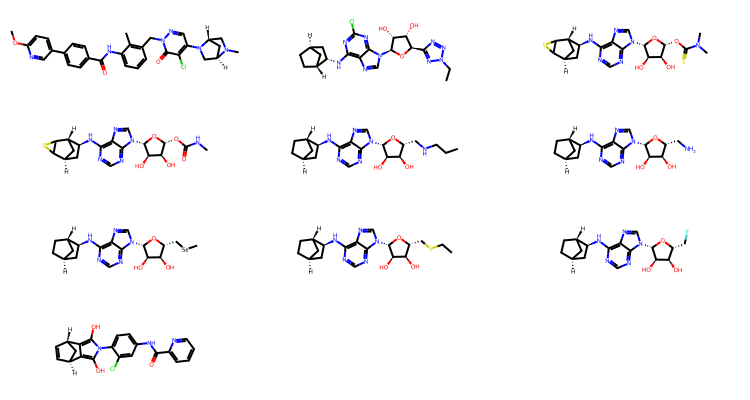

In [28]:
unique_failed_smis = []
for file, failed_dict in hhd_gpcr_failed.items():
    for idx, smi in failed_dict.items():
        if smi not in unique_failed_smis:
            unique_failed_smis.append(smi)
for file, failed_dict in mhd_gpcr_failed.items():
    for idx, smi in failed_dict.items():
        if smi not in unique_failed_smis:
            unique_failed_smis.append(smi)
print(f'The total number of unique failed SMILES: {len(unique_failed_smis)}')

display_2d_smi(unique_failed_smis, save_path=FEAT_FIG_DIR)

## Featurized dataset

In [31]:
in_dir = os.path.join(FEAT_HHD_OR_DIR, 'all')

feat_files = [f for f in os.listdir(in_dir)]
print(f'feat_files: {feat_files}')

feat_dfs = {}
for f in feat_files:
    df = pd.read_pickle(os.path.join(in_dir, f))
    print(f'The shape of {f}: {df.shape}')
    feat_dfs[f] = df

feat_files: ['CHEMBL233_IC50_hhd_b50_featurized.pkl', 'CHEMBL237_EC50_hhd_b50_featurized.pkl', 'CHEMBL233_Ki_hhd_b50_featurized.pkl', 'CHEMBL2014_Ki_hhd_b50_featurized.pkl', 'CHEMBL236_Ki_hhd_b50_featurized.pkl', 'CHEMBL236_IC50_hhd_b50_featurized.pkl', 'CHEMBL2014_IC50_hhd_b50_featurized.pkl', 'CHEMBL236_EC50_hhd_b50_featurized.pkl', 'CHEMBL233_EC50_hhd_b50_featurized.pkl', 'CHEMBL2014_EC50_hhd_b50_featurized.pkl', 'CHEMBL237_Ki_hhd_b50_featurized.pkl', 'CHEMBL237_IC50_hhd_b50_featurized.pkl']
The shape of CHEMBL233_IC50_hhd_b50_featurized.pkl: (1005, 61)
The shape of CHEMBL237_EC50_hhd_b50_featurized.pkl: (1357, 61)
The shape of CHEMBL233_Ki_hhd_b50_featurized.pkl: (4535, 61)
The shape of CHEMBL2014_Ki_hhd_b50_featurized.pkl: (1166, 61)
The shape of CHEMBL236_Ki_hhd_b50_featurized.pkl: (3933, 61)


: 

### Indivisual pkl files

In [3]:
feat_hhd_or_f1 = pd.read_pickle(os.path.join(FEAT_HHD_OR_DIR, 'all', 'CHEMBL233_Ki_hhd_b50_featurized.pkl'))
print(f'The shape of feat_hhd_or_f1: {feat_hhd_or_f1.shape}')
print(f'The columns in feat.pkl: \n{feat_hhd_or_f1.columns}\n')
# the last 13 columns are the features
feat_hhd_or_f1.iloc[:, -13:].head(1)

The shape of feat_hhd_or_f1: (4535, 61)
The columns in feat.pkl: 
Index(['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id',
       'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'pchembl_value', 'assay_type', 'assay_type_desc',
       'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain',
       'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
       'bao_format', 'bao_label', 'variant_id', 'assay_test_type',
       'assay_desc', 'cell_id', 'tissue_id', 'curated_by', 'relationship_type',
       'relationship_type_desc', 'aidx', 'confidence_score',
       'confidence_score_desc', 'molregno', 'compound_chembl_id',
       'canonical_smiles', 'assay_info_hash', 'canonical_smiles_by_Std',
       'molecular_weight', 'num_atoms', 'pStandard_value', 'max_num_atoms',
       'max_molecular_weight', 'activity_string', 'activity', 'threshold',
       'target', 'effect', 'assay', 'std_type', 'ECFP4', 'ECFP6', 'MACCS',
       'RDK

,ECFP4,ECFP6,MACCS,RDKITFP,PHARM2D,ERG,PHYSICOCHEM,SHAPE3D,AUTOCORR3D,RDF,MORSE,WHIM,GETAWAY
0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[300.139326352, 4.175300000000003, 1.0, 2.0, 4...","[1.1422379411654762, 1498.4217979977054, 1933....","[0.066, 0.199, 0.369, 0.515, 0.68, 0.745, 0.68...","[10.1, 13.473, 5.551, 34.557, 20.733, 23.504, ...","[861.0, 8.393, -5.596, 2.435, -5.84, -3.007, 3...","[5.4, 4.343, 1.808, 0.467, 0.376, 0.156, 0.156...","[81.484, 0.883, 5.217, 6.215, 3.0, 2.297, 3.00..."


In [24]:
feat_hhd_or_f1['curated_by'].value_counts()

curated_by
Autocuration    3029
Expert          1134
Intermediate     372
Name: count, dtype: int64

In [17]:
ecfp_00_list = feat_hhd_or_f1['ECFP4'][0][0].tolist()
print(f'The lenght of ecfp_00_list: {len(ecfp_00_list)}')

ecfp_0_list = feat_hhd_or_f1['ECFP4'][0].tolist()
print(f'The lenght of ecfp_0_list: {len(ecfp_0_list)}')

ecfp_list = feat_hhd_or_f1['ECFP4'].tolist()
print(f'The lenght of ecfp_list: {len(ecfp_list)}')

smiles_list = feat_hhd_or_f1['canonical_smiles_by_Std'].tolist()
print(f'The lenght of smiles_list: {len(smiles_list)}')

The lenght of ecfp_00_list: 1024
The lenght of ecfp_0_list: 1
The lenght of ecfp_list: 4535
The lenght of smiles_list: 4535


In [ ]:
feat_hhd_or_f1['SHAPE3D'][0][0]

array([1.14223794e+00, 1.49842180e+03, 1.93321135e+03, 2.51983854e+03,
       5.94649925e-01, 7.67196517e-01, 3.14509994e+00, 5.12003041e-04,
       8.03984742e-01, 8.90155216e-02, 4.69698108e-01])

In [16]:
feat_hhd_gpcr_f1 = pd.read_pickle(os.path.join(FEAT_HHD_GPCR_DIR, 'all', 'CHEMBL233_Ki_hhd_b50_featurized.pkl'))
# the last 13 columns are the features
feat_hhd_gpcr_f1.iloc[:, -13:].head(1)

,ECFP4,ECFP6,MACCS,RDKITFP,PHARM2D,ERG,PHYSICOCHEM,SHAPE3D,AUTOCORR3D,RDF,MORSE,WHIM,GETAWAY
0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[300.139326352, 4.175300000000003, 1.0, 2.0, ...","[[1.1422379411654762, 1498.4217979977054, 1933...","[[0.066, 0.199, 0.369, 0.515, 0.68, 0.745, 0.6...","[[10.1, 13.473, 5.551, 34.557, 20.733, 23.504,...","[[861.0, 8.393, -5.596, 2.435, -5.84, -3.007, ...","[[5.4, 4.343, 1.808, 0.467, 0.376, 0.156, 0.15...","[[81.484, 0.883, 5.217, 6.215, 3.0, 2.297, 3.0..."


In [43]:
failed_smis = feat_hhd_or_f1['GETAWAY'].isna() == True
failed_smis

0       False
1       False
2       False
3       False
4       False
        ...  
4530    False
4531    False
4532    False
4533    False
4534    False
Name: GETAWAY, Length: 4535, dtype: bool

In [70]:
print(f"The shape of feat_hhd_or_f1[MORSE'][0]: {feat_hhd_or_f1['GETAWAY'][0].shape}")
print(f"The shape of feat_hhd_gpcr_f1[MORSE'][0]: {feat_hhd_gpcr_f1['GETAWAY'][0].shape}")

The shape of feat_hhd_or_f1[MORSE'][0]: (1, 273)
The shape of feat_hhd_gpcr_f1[MORSE'][0]: (1, 273)


### Merge all featurized pkl files 
into one dataframe, i.e. append the descriptors to the original dataframe.

### Featurization stats

# Encode

In [6]:
compound_names_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'compound_names.parquet'))
compound_smiles_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'compound_smiles.parquet'))
activity_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'activity.parquet'))
assay_info_df = pd.read_parquet(os.path.join(SPLIT_DATA_DIR, 'fsmol_alike', 'MHDsFold', 'assay_info.parquet'))
print(f'The shape of compound_names_df: {compound_names_df.shape}\n'
      f'compound_names_df.columns: {compound_names_df.columns}\n'
      f'The shape of compound_smiles_df: {compound_smiles_df.shape}\n'
      f'compound_smiles_df.columns: {compound_smiles_df.columns}\n'
      f'The shape of activity_df: {activity_df.shape}\n'
      f'activity_df.columns: {activity_df.columns}\n'
      f'The shape of assay_info_df: {assay_info_df.shape}\n'
      f'assay_info_df.columns: {assay_info_df.columns}\n')

The shape of compound_names_df: (118736, 1)
compound_names_df.columns: Index(['CID'], dtype='object')
The shape of compound_smiles_df: (118736, 2)
compound_smiles_df.columns: Index(['CID', 'CanonicalSMILES'], dtype='object')
The shape of activity_df: (211506, 5)
activity_df.columns: Index(['compound_idx', 'assay_idx', 'activity', 'activity_numeric', 'split'], dtype='object')
The shape of assay_info_df: (18292, 30)
assay_info_df.columns: Index(['assay_idx', 'assay_id', 'assay_chembl_id', 'assay_description',
       'assay_type', 'assay_type_description', 'assay_category',
       'assay_organism', 'assay_tax_id', 'assay_strain', 'assay_tissue',
       'assay_cell_type', 'assay_subcellular_fraction', 'bao_format',
       'bao_label', 'variant_id', 'assay_test_type', 'cell_id', 'tissue_id',
       'relationship_type', 'relationship_type_description', 'aidx',
       'confidence_score', 'confidence_score_description', 'tid',
       'target_chembl_id', 'effect', 'effect_description', 'assay',

In [21]:
assay_info_df['curated_by'].value_counts()

KeyError: 'curated_by'

In [15]:
assay_info_df['tid'].value_counts()

tid
72        805
129       742
137       669
136       624
51        623
         ... 
100138      1
103163      1
105189      1
109761      1
102648      1
Name: count, Length: 203, dtype: int64

## Encode compound

In [5]:
compound_names_df

,CID
0,0
1,1
2,2
3,3
4,4
...,...
118731,118731
118732,118732
118733,118733
118734,118734


## Encode assay